In [209]:
import re
import string
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

'''
Import below doesn't needed for basic solution
It is just for experimentations
'''
import nltk
from nltk.corpus import stopwords
# Remove below comments to add necessary libraries
# import sys
# !{sys.executable} -m pip install --user -U pandas xgboost nltk graphviz
import xgboost as xgb
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /home/oak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oak/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [61]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

'''
Testing multiple classification Algorithm for a best fit
'''
classifiers = {
    'dummy' : DummyClassifier(),
    'linear_regression' : LinearRegression(),
    'gnb' : GaussianNB(),
    'random_forest' : RandomForestClassifier(n_estimators=100, max_depth=10, max_features=6),
    #'ada' : AdaBoostClassifier(),
    #'mlp' : MLPClassifier(alpha=1, max_iter=1000),
    'XGB': XGBClassifier(n_estimators=100, max_depth=7)
}




#### Helper Methods to transfor/extrac information

In [4]:
def get_sentiment(text):
    ''' Get sentiments from tweets '''
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [5]:
def get_tags_count(text):
    '''Get POS tags from a tweet'''
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    counts = Counter( tag for word,  tag in tags)
    return dict(counts)

In [6]:
def filter_stop_words(text):
    ''' Filter out stop words (Only for English text)'''
    filter_words = [x for x in text if x not in stopwords.words('english')]
    return filter_words

In [75]:
def unique_word_ratio(words):
    ''' Get unique words ratio'''
    word_count = len(words)
    if not word_count:
        return 0
    
    unique_count = len(set(words))
    return unique_count / word_count

In [8]:
def get_most_used_words(token):
    ''' Get most words used from a tokinized list'''
    return nltk.FreqDist(token)

In [9]:
def most_words_by_author(authors):
    ''' Group top words used by author '''
    top_words_by_author = dict()
    for x in authors:
        author_clean_tokens = df[df['author']== x ]['clean_tokens'].tolist()
        flat_list = [item for sublist in author_clean_tokens for item in sublist]
        top_words_by_author[x] = [item[0] for item in get_most_used_words(flat_list).most_common(10)]
        
    return top_words_by_author

In [10]:
def mark_common_word(author, tokens):
    ''' Filter out common words of a author from a tweet '''
    common_words = author_top_10_words[author]
    common_word_used = []
    for token in tokens:
        if token in common_words:
            common_word_used.append(token)
    
    return common_word_used

In [141]:
df = pd.read_csv('train_set.csv', sep=',')
df_test = pd.read_csv('test_set.csv', sep=',')

# Droping incosistent(Null) data
df = df.dropna()

In [106]:
df.head(5)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,source,lang,is_retweet,has_hashtag,has_mentions,has_url,has_media,tweet
0,Neil deGrasse Tyson,3.0,2.0,2014.0,1.0,58.0,8.0,Mon,34.0,5.0,7.0,en,False,False,False,False,False,A 50-yard field goal in MetLife stadium will d...
1,Cristiano Ronaldo,22.0,12.0,2012.0,13.0,57.0,5.0,Sat,357.0,51.0,0.0,pt,False,True,True,False,False,RT @Thiaguinhooo14: Manda um abraço em portugu...
2,Ellen DeGeneres,22.0,3.0,2019.0,18.0,58.0,24.0,Fri,81.0,11.0,1.0,en,False,False,False,False,True,Today I’m talking about a topic that affects a...
3,Sebastian Ruder,13.0,6.0,2016.0,18.0,13.0,55.0,Mon,165.0,24.0,7.0,en,False,True,False,True,False,New blog post giving an overview of softmax ap...
4,KATY PERRY,18.0,4.0,2018.0,6.0,56.0,54.0,Wed,108.0,16.0,0.0,en,False,False,True,True,False,high of the day: 0 cavities 🙏🏻\nlow: @washingt...


#### Target class Mapping

In [229]:
dict( enumerate(df['author'].astype('category').cat.categories ) )

{0: 'Barack Obama',
 1: 'Cristiano Ronaldo',
 2: 'Donald J. Trump',
 3: 'Ellen DeGeneres',
 4: 'Elon Musk',
 5: 'KATY PERRY',
 6: 'Kim Kardashian West',
 7: 'Neil deGrasse Tyson',
 8: 'Sebastian Ruder',
 9: 'Snoop Dogg'}

#### Visualizing some useful stats

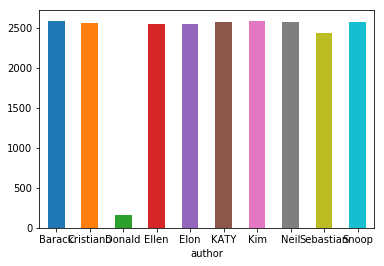

In [142]:
df['author'] = df.apply(lambda row: row['author'].split(" ")[0], axis=1)
df.groupby('author').count()['lang'].plot.bar(x='author', y='count', rot=0)

We have one imbalanced class "Donald Trump" within a dataset, it may suffer from precision if left at it is.

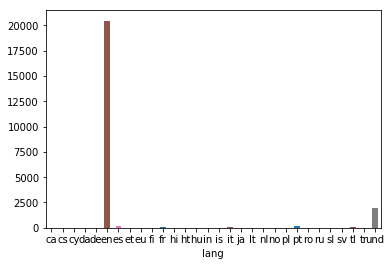

In [143]:
df.groupby('lang').count()['author'].plot.bar(x='lang', y='count', rot=0)

The dataset contains a few multiple languages, but still, "en" English language is dominating. Again for simplicity we will work over the English language as a base Langugae for our solution. Although our basic solution is language independent.

In [231]:
df['author_numeric'] = df['author'].astype('category').cat.codes
df['lang_numeric'] = df['lang'].astype('category').cat.codes
df['day_of_week_numeric'] = df['day_of_week'].astype('category').cat.codes
df['has_mentions'] = df['has_mentions'].astype('category').cat.codes
df['is_retweet'] = df['is_retweet'].astype('category').cat.codes
df['has_hashtag'] = df['has_hashtag'].astype('category').cat.codes
df['has_url'] = df['has_url'].astype('category').cat.codes
df['has_media'] = df['has_media'].astype('category').cat.codes
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/lib/python3/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,day,month,year,hour,minute,second,day_of_year,week_of_year,source,is_retweet,has_hashtag,has_mentions,has_url,has_media,tweet_length,punc_count,punc_ratio,unique_ratio,lang_numeric,day_of_week_numeric,word_count,author_numeric
day,1,-0.00677015,-0.00122407,-0.00199287,0.00413236,-0.0076431,0.0809276,0.0807925,-6.90549e-05,nan,-0.00927827,-0.00299876,0.0222063,0.00692653,-0.00387092,0.00500665,-0.00132565,0.00496966,0.0115671,-0.0176289,-0.00559718,0.0100136
month,-0.00677015,1,-0.114846,0.0596859,0.0146015,0.0069516,0.996123,0.995685,-0.0557315,nan,-0.016578,-0.0156642,0.0382387,0.0200361,-0.0115283,-0.00627069,0.0114558,0.0239867,0.0123931,-0.0300092,-0.0235567,-0.0154799
year,-0.00122407,-0.114846,1,-0.092317,0.00140788,0.0277662,-0.115889,-0.117208,-0.465751,nan,-0.0877627,0.197416,0.0414157,0.0351509,-0.0842157,-0.0601527,0.0201393,0.111988,0.0707779,0.000918927,-0.0834921,0.289824
hour,-0.00199287,0.0596859,-0.092317,1,0.00964866,-0.0121509,0.0595529,0.0582205,0.0448334,nan,-0.00647992,-0.0087933,0.0803122,0.0601525,0.108483,0.123514,0.00366631,-0.0718107,-0.0571708,0.0413936,0.0789287,-0.153019
minute,0.00413236,0.0146015,0.00140788,0.00964866,1,0.026857,0.0149434,0.0146471,-0.0131161,nan,-0.0182279,0.000905113,-0.0129164,-0.0027565,-0.021287,-0.0150409,0.0121089,0.0169147,0.00104528,0.00773474,-0.0223451,0.0118655
second,-0.0076431,0.0069516,0.0277662,-0.0121509,0.026857,1,0.00626408,0.00631279,-0.0531921,nan,-0.0222026,0.0104786,0.00787958,0.0183768,-0.0289434,-0.0165529,0.0238755,0.032084,0.0149547,0.0120614,-0.027601,-0.0321651
day_of_year,0.0809276,0.996123,-0.115889,0.0595529,0.0149434,0.00626408,1,0.999555,-0.0552036,nan,-0.0170529,-0.0159566,0.0398011,0.020162,-0.0115817,-0.00567941,0.0112779,0.0240878,0.0127231,-0.0312746,-0.0236346,-0.0154248
week_of_year,0.0807925,0.995685,-0.117208,0.0582205,0.0146471,0.00631279,0.999555,1,-0.0515405,nan,-0.0153683,-0.0175668,0.0424314,0.0226668,-0.012892,-0.00441699,0.0132832,0.0259481,0.0152725,-0.0272952,-0.0253213,-0.010152
source,-6.90549e-05,-0.0557315,-0.465751,0.0448334,-0.0131161,-0.0531921,-0.0552036,-0.0515405,1,nan,-0.0773517,-0.0555122,0.0796788,-0.0609509,0.103876,0.109626,-0.043388,-0.119891,0.0182142,0.0147725,0.0893793,0.146249
is_retweet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


This correlation matrix can provide us with a handy vision to select impactful parameters. As our target is author, we can see that the parameters below look promising feature set for training

- year
- source
- has_mentions
- hour
- has_hashtag
- lang_numeric

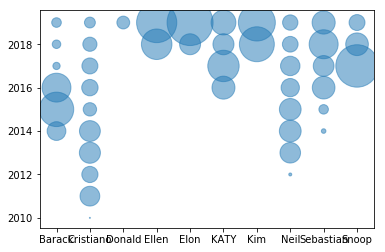

In [145]:
author_year_group = df.groupby(['author', 'year']).count()['day']
N = 10
colors = np.random.rand(N)

plt.scatter(author_year_group.index.get_level_values(0), author_year_group.index.get_level_values(1), s=author_year_group.values, alpha=0.5)
plt.show()

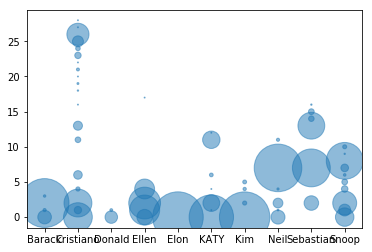

In [146]:
author_year_group = df.groupby(['author', 'source']).count()['day']
N = 10
colors = np.random.rand(N)

plt.scatter(author_year_group.index.get_level_values(0), author_year_group.index.get_level_values(1), s=author_year_group.values, alpha=0.5)
plt.show()

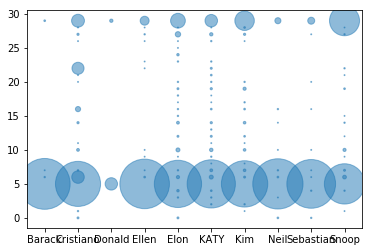

In [147]:
author_year_group = df.groupby(['author', 'lang_numeric']).count()['day']
N = 10
colors = np.random.rand(N)

plt.scatter(author_year_group.index.get_level_values(0), author_year_group.index.get_level_values(1), s=author_year_group.values, alpha=0.5)
plt.show()

Lets just try our luck with these handful parameters, and see what shows up.

In [122]:
target = df['author_numeric']
data = df[['source', 'year', 'lang_numeric', 'hour', 'has_mentions', 'has_hashtag']]

In [123]:
for k, v in classifiers.items():
    results = cross_val_score(v, data, target, cv=5)
    print(k)
    print(results)

dummy
[0.11731723 0.10056107 0.10792143 0.11509393 0.1036941 ]
linear_regression
[0.22995842 0.2164969  0.22565512 0.21221584 0.2411846 ]
gnb
[0.5943498  0.59236081 0.58385495 0.59144893 0.58241521]
random_forest
[0.76989433 0.77665084 0.77012735 0.75534442 0.76604018]
XGB
[0.77269786 0.77772982 0.77034319 0.76700497 0.76971268]


#### It looks like we already achieved our base score by just analysing corelations between features and targets.

Now lets do reverse engineering, feeding every parameter in a model and check which one it picks to provide more information gain

In [149]:
target = df['author_numeric']
data = df.drop(['author', 'tweet', 'day_of_week', 'lang', 'author_numeric'], axis=1)

In [150]:
for k, v in classifiers.items():
    results = cross_val_score(v, data, target, cv=5)
    print(k)
    print(results)

dummy
[0.10610308 0.10703496 0.0982085  0.11271864 0.1058544 ]
linear_regression
[0.26249704 0.25047481 0.25333796 0.24210176 0.27185383]
gnb
[0.63381497 0.64285714 0.62141161 0.63593176 0.63037373]
random_forest
[0.83308173 0.84333189 0.83272178 0.83049017 0.83365738]
XGB
[0.85184386 0.85347432 0.84998921 0.84193479 0.85007561]


Its look like we reached our goal, but which is the feature that we missed and it provided such a boost? Lets check it with feature imporatance tool of a model

In [151]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=6)
clf.fit(data, target)
cross_val_score(clf, data, target, cv=5)
#get_xgb_imp(clf, data.columns)

array([0.83459133, 0.84441088, 0.83358515, 0.83156986, 0.83106502])

Feature ranking:
1. feature 8 (0.356490)
2. feature 2 (0.280102)
3. feature 3 (0.060904)
4. feature 13 (0.048961)
5. feature 6 (0.042167)
6. feature 12 (0.036852)
7. feature 11 (0.034603)
8. feature 7 (0.031746)
9. feature 10 (0.028550)
10. feature 14 (0.022739)
11. feature 1 (0.016175)
12. feature 15 (0.010848)
13. feature 0 (0.010789)
14. feature 5 (0.009860)
15. feature 4 (0.009214)
16. feature 9 (0.000000)


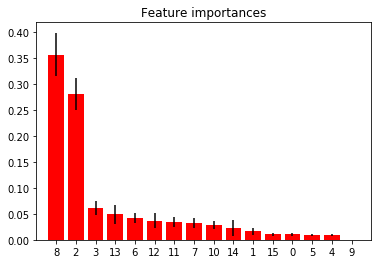

In [152]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

In [153]:
data.columns

Index(['day', 'month', 'year', 'hour', 'minute', 'second', 'day_of_year',
       'week_of_year', 'source', 'is_retweet', 'has_hashtag', 'has_mentions',
       'has_url', 'has_media', 'lang_numeric', 'day_of_week_numeric'],
      dtype='object')

Gotchaaaa, so as per our Random Tree forest and XGB, we found out that "has_media" and "day_of_year" are providing much of the information which we were not able to see through corelation matrix.

Lets add these two parameters to our previous handful feature and see if it is actually true.

In [154]:
target = df['author_numeric']
data = df[['source', 'year', 'lang_numeric', 'hour', 'has_mentions', 'has_hashtag', 'has_media', 'day_of_year']]

In [155]:
for k, v in classifiers.items():
    results = cross_val_score(v, data, target, cv=5)
    print(k)
    print(results)

dummy
[0.11257278 0.10617177 0.11051155 0.11703736 0.1073666 ]
linear_regression
[0.23399045 0.21911337 0.22596606 0.21694496 0.24468854]
gnb
[0.63295234 0.63746224 0.61838981 0.63679551 0.62367682]
random_forest
[0.83265042 0.83340527 0.83164256 0.82725113 0.82523223]
XGB
[0.841708   0.84354769 0.84221886 0.83740013 0.83624973]


In [194]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=6)
clf.fit(data, target)
cross_val_score(clf, data, target, cv=5)
#get_xgb_imp(clf, data.columns)

array([0.79965495, 0.80750971, 0.80228793, 0.79140574, 0.79887665])

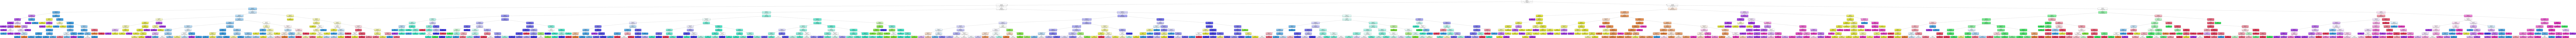

In [206]:
# Extract single tree
estimator = clf.estimators_[1]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = data.columns,
                class_names = df['author'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Try to visualize it but its quite long

#### Predicting test script

In [221]:
df_test['lang_numeric'] = df_test['lang'].astype('category').cat.codes
#df_test['day_of_week'] = df_test['day_of_week'].astype('category').cat.codes
df_test['day_of_week_numeric'] = df_test['day_of_week'].astype('category').cat.codes
df_test['has_mentions'] = df_test['has_mentions'].astype('category').cat.codes
df_test['is_retweet'] = df_test['is_retweet'].astype('category').cat.codes
df_test['has_hashtag'] = df_test['has_hashtag'].astype('category').cat.codes
df_test['has_url'] = df_test['has_url'].astype('category').cat.codes
df_test['has_media'] = df_test['has_media'].astype('category').cat.codes
#df_test.head(4)
df_test_data = data = df_test[['source', 'year', 'lang_numeric', 'hour', 'has_mentions', 'has_hashtag', 'has_media', 'day_of_year']]
results = clf.predict(df_test_data)

[1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 7,
 1,
 7,
 7,
 1,
 1,
 1,
 7,
 7,
 1,
 7,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 7,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 7,
 1,
 1,
 7,


##### For conclusion, the ensemble method usually provides better result as it selects best models and then aggreagates it. Randomforest particularly creates multiple trees with different parameters and then combine the results. Which is why set of features were enough to provide max accuracy and thus new feature didn't provide much of a change in the result.

### Although we reached our goal, and you can ignore the below Implementations
### These are just a few experiments. 

##### Let paly with some langugae stats, and see if we can make this score much better or not

In [157]:
df = pd.read_csv('train_set.csv', sep=',')
df_test = pd.read_csv('test_set.csv', sep=',')

# Droping incosistent(Null) data
df = df.dropna()
df['tweet'].head(10)

0    A 50-yard field goal in MetLife stadium will d...
1    RT @Thiaguinhooo14: Manda um abraço em portugu...
2    Today I’m talking about a topic that affects a...
3    New blog post giving an overview of softmax ap...
4    high of the day: 0 cavities 🙏🏻\nlow: @washingt...
5    @PrintingJesus Yup. I occasionally repost afte...
6    RT @tdietterich: These rules are full of wisdo...
7    RT @kkwbeauty: BOGO! Buy one Crème Contour Sti...
8    RT @kkwbeauty: The new Body Shimmer in Gold is...
9    My 13th surprise bday party 1993 https://t.co/...
Name: tweet, dtype: object

In [158]:
# Lets apply some basic NLP statistical methods

# lowering all text
df['tweet'] = df['tweet'].apply(lambda x: x.lower())

# removing retweets tags as we already know  which indecate re
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'^rt.*:', '', x))

# removing url
#df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# tweet character length
df['tweet_length'] = df['tweet'].apply(lambda x: len(x))

# punctuation count and ratio in a tweet
df['punc_count'] = df['tweet'].apply(lambda t: len(list(filter(lambda c: c in t, string.punctuation))))
df['punc_ratio'] = df['punc_count'] / df['tweet_length']

# remvoing some special characters
punc_plus_extra = '{}{}'.format(string.punctuation, '“”—')

df['tweet_no_punc'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', punc_plus_extra)))
df['tweet_no_punc'] = df['tweet_no_punc'].apply(lambda x: x.replace('’', ''))
df['tweet_no_punc'] = df['tweet_no_punc'].apply(lambda x: x.replace('amp', ''))

# find unique word ratio
df['unique_ratio'] = df['tweet_no_punc'].apply(lambda x: unique_word_ratio(x))

#df['sentiment'] = df['tweet'].apply(lambda x: get_sentiment(x))

In [159]:
df.head(10)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,...,has_hashtag,has_mentions,has_url,has_media,tweet,tweet_length,punc_count,punc_ratio,tweet_no_punc,unique_ratio
0,Neil deGrasse Tyson,3.0,2.0,2014.0,1.0,58.0,8.0,Mon,34.0,5.0,...,False,False,False,False,a 50-yard field goal in metlife stadium will d...,119,3,0.025210,a 50yard field goal in metlife stadium will de...,0.201754
1,Cristiano Ronaldo,22.0,12.0,2012.0,13.0,57.0,5.0,Sat,357.0,51.0,...,True,True,False,False,manda um abraço em português para seus fás no...,82,3,0.036585,manda um abraço em português para seus fás no...,0.291139
2,Ellen DeGeneres,22.0,3.0,2019.0,18.0,58.0,24.0,Fri,81.0,11.0,...,False,False,False,True,today i’m talking about a topic that affects a...,94,4,0.042553,today im talking about a topic that affects al...,0.270588
3,Sebastian Ruder,13.0,6.0,2016.0,18.0,13.0,55.0,Mon,165.0,24.0,...,True,False,True,False,new blog post giving an overview of softmax ap...,140,4,0.028571,new blog post giving an overview of softmax ap...,0.187970
4,KATY PERRY,18.0,4.0,2018.0,6.0,56.0,54.0,Wed,108.0,16.0,...,False,True,True,False,high of the day: 0 cavities 🙏🏻\nlow: @washingt...,140,5,0.035714,high of the day 0 cavities 🙏🏻\nlow washingtonp...,0.232558
5,Neil deGrasse Tyson,7.0,12.0,2016.0,0.0,48.0,0.0,Wed,342.0,49.0,...,False,True,False,False,@printingjesus yup. i occasionally repost afte...,125,2,0.016000,printingjesus yup i occasionally repost after ...,0.178862
6,Sebastian Ruder,29.0,3.0,2017.0,3.0,20.0,59.0,Wed,88.0,13.0,...,True,True,False,False,these rules are full of wisdom. every univers...,124,2,0.016129,these rules are full of wisdom every universi...,0.188525
7,Kim Kardashian West,6.0,4.0,2019.0,17.0,49.0,1.0,Sat,96.0,13.0,...,False,True,False,False,"59pm pst, while supplies…",25,1,0.040000,59pm pst while supplies…,0.583333
8,Kim Kardashian West,22.0,6.0,2019.0,0.0,27.0,43.0,Sat,173.0,24.0,...,False,True,True,False,//t.co/32qakbs5yg…,18,2,0.111111,tco32qakbs5yg…,1.000000
9,Kim Kardashian West,29.0,3.0,2019.0,8.0,33.0,16.0,Fri,88.0,12.0,...,False,False,False,True,my 13th surprise bday party 1993 https://t.co/...,56,3,0.053571,my 13th surprise bday party 1993 httpstcow79gi...,0.450980


##### Now lets find correlation of these new parameters

In [160]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,day,month,year,hour,minute,second,day_of_year,week_of_year,source,tweet_length,punc_count,punc_ratio,unique_ratio
day,1,-0.00677015,-0.00122407,-0.00199287,0.00413236,-0.0076431,0.0809276,0.0807925,-6.90549e-05,-0.00387092,0.00500665,-0.00132565,0.00496966
month,-0.00677015,1,-0.114846,0.0596859,0.0146015,0.0069516,0.996123,0.995685,-0.0557315,-0.0115283,-0.00627069,0.0114558,0.0239867
year,-0.00122407,-0.114846,1,-0.092317,0.00140788,0.0277662,-0.115889,-0.117208,-0.465751,-0.0842157,-0.0601527,0.0201393,0.111988
hour,-0.00199287,0.0596859,-0.092317,1,0.00964866,-0.0121509,0.0595529,0.0582205,0.0448334,0.108483,0.123514,0.00366631,-0.0718107
minute,0.00413236,0.0146015,0.00140788,0.00964866,1,0.026857,0.0149434,0.0146471,-0.0131161,-0.021287,-0.0150409,0.0121089,0.0169147
second,-0.0076431,0.0069516,0.0277662,-0.0121509,0.026857,1,0.00626408,0.00631279,-0.0531921,-0.0289434,-0.0165529,0.0238755,0.032084
day_of_year,0.0809276,0.996123,-0.115889,0.0595529,0.0149434,0.00626408,1,0.999555,-0.0552036,-0.0115817,-0.00567941,0.0112779,0.0240878
week_of_year,0.0807925,0.995685,-0.117208,0.0582205,0.0146471,0.00631279,0.999555,1,-0.0515405,-0.012892,-0.00441699,0.0132832,0.0259481
source,-6.90549e-05,-0.0557315,-0.465751,0.0448334,-0.0131161,-0.0531921,-0.0552036,-0.0515405,1,0.103876,0.109626,-0.043388,-0.119891
tweet_length,-0.00387092,-0.0115283,-0.0842157,0.108483,-0.021287,-0.0289434,-0.0115817,-0.012892,0.103876,1,0.58465,-0.557407,-0.891536


New parameters are impact directly to the author with some average correlation, which can provide an assist to model with their acummulated support

In [165]:
target = df['author'].astype('category').cat.codes
df['lang_numeric'] = df['lang'].astype('category').cat.codes
df['day_of_week_numeric'] = df['day_of_week'].astype('category').cat.codes
df['has_mentions'] = df['has_mentions'].astype('category').cat.codes
df['is_retweet'] = df['is_retweet'].astype('category').cat.codes
df['has_hashtag'] = df['has_hashtag'].astype('category').cat.codes
df['has_url'] = df['has_url'].astype('category').cat.codes
df['has_media'] = df['has_media'].astype('category').cat.codes
data = df[['source', 'year', 'lang_numeric', 'hour', 'has_mentions', 'has_hashtag', 'has_media', 'day_of_year', 'tweet_length', 'unique_ratio', 'punc_ratio', 'punc_count']]

In [166]:
for k, v in classifiers.items():
    results = cross_val_score(v, data, target, cv=5)
    print(k)
    print(results)

dummy
[0.10610308 0.10746655 0.10641053 0.1071043  0.11168719]
linear_regression
[0.23535246 0.22117424 0.22706116 0.21678906 0.24610826]
gnb
[0.6172094  0.62278809 0.60997194 0.62772619 0.61330741]
random_forest
[0.83416002 0.83664221 0.83056335 0.82811488 0.83041694]
XGB
[0.8531378  0.85627967 0.84934168 0.85143597 0.84899546]


#### These implementation failed miserably, as the model take branches w.r.t to high infomration gain, thus these new parameter always comes under previous impacted parameters.

#### Below this I try to use NLTK, just curious if it can help

In [167]:
df['tokens'] = df['tweet_no_punc'].apply(lambda x: nltk.word_tokenize(x))
df.head(5)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,...,has_media,tweet,tweet_length,punc_count,punc_ratio,tweet_no_punc,unique_ratio,lang_numeric,day_of_week_numeric,tokens
0,Neil deGrasse Tyson,3.0,2.0,2014.0,1.0,58.0,8.0,Mon,34.0,5.0,...,0,a 50-yard field goal in metlife stadium will d...,119,3,0.025210,a 50yard field goal in metlife stadium will de...,0.201754,5,1,"[a, 50yard, field, goal, in, metlife, stadium,..."
1,Cristiano Ronaldo,22.0,12.0,2012.0,13.0,57.0,5.0,Sat,357.0,51.0,...,0,manda um abraço em português para seus fás no...,82,3,0.036585,manda um abraço em português para seus fás no...,0.291139,22,2,"[manda, um, abraço, em, português, para, seus,..."
2,Ellen DeGeneres,22.0,3.0,2019.0,18.0,58.0,24.0,Fri,81.0,11.0,...,1,today i’m talking about a topic that affects a...,94,4,0.042553,today im talking about a topic that affects al...,0.270588,5,0,"[today, im, talking, about, a, topic, that, af..."
3,Sebastian Ruder,13.0,6.0,2016.0,18.0,13.0,55.0,Mon,165.0,24.0,...,0,new blog post giving an overview of softmax ap...,140,4,0.028571,new blog post giving an overview of softmax ap...,0.187970,5,1,"[new, blog, post, giving, an, overview, of, so..."
4,KATY PERRY,18.0,4.0,2018.0,6.0,56.0,54.0,Wed,108.0,16.0,...,0,high of the day: 0 cavities 🙏🏻\nlow: @washingt...,140,5,0.035714,high of the day 0 cavities 🙏🏻\nlow washingtonp...,0.232558,5,6,"[high, of, the, day, 0, cavities, 🙏🏻, low, was..."


In [168]:
df['clean_tokens'] = df['tokens'].apply(lambda x: filter_stop_words(x))
df[['tokens', 'clean_tokens']].head(5)

,tokens,clean_tokens
0,"[a, 50yard, field, goal, in, metlife, stadium,...","[50yard, field, goal, metlife, stadium, deflec..."
1,"[manda, um, abraço, em, português, para, seus,...","[manda, um, abraço, em, português, para, seus,..."
2,"[today, im, talking, about, a, topic, that, af...","[today, im, talking, topic, affects, us, mansp..."
3,"[new, blog, post, giving, an, overview, of, so...","[new, blog, post, giving, overview, softmax, a..."
4,"[high, of, the, day, 0, cavities, 🙏🏻, low, was...","[high, day, 0, cavities, 🙏🏻, low, washingtonpo..."


In [169]:
#df['top_words'] = df['clean_tokens'].apply(lambda words: list(get_most_used_words(words).keys())[:5])
author_top_10_words = most_words_by_author(pd.unique(df['author']))
df['top_words_used'] = df.apply(lambda row: mark_common_word(row['author'], row['clean_tokens']), axis=1)


In [170]:
author_top_10_words

{'Neil deGrasse Tyson': ['earth',
  'moon',
  'would',
  'posted',
  'people',
  'one',
  'time',
  'day',
  'w',
  'science'],
 'Cristiano Ronaldo': ['cristiano',
  'new',
  'great',
  'game',
  'madrid',
  'thank',
  'team',
  'win',
  'im',
  'good'],
 'Ellen DeGeneres': ['happy',
  'gameofgames',
  'birthday',
  'show',
  'im',
  'love',
  'new',
  'youre',
  'time',
  'watch'],
 'Sebastian Ruder': ['learning',
  'nlp',
  'thanks',
  'new',
  'paper',
  'deeplearning',
  'great',
  'machinelearning',
  'work',
  'nlproc'],
 'KATY PERRY': ['americanidol',
  'love',
  'im',
  'get',
  'time',
  'new',
  'see',
  'one',
  'like',
  'dont'],
 'Kim Kardashian West': ['kkwbeauty',
  'new',
  'shop',
  'collection',
  'love',
  'pst',
  'available',
  'today',
  'get',
  'classic'],
 'Snoop Dogg': ['n',
  'new',
  'snoopdogg',
  'wit',
  'u',
  'get',
  'snoop',
  'jokerswild',
  'got',
  'yall'],
 'Elon Musk': ['tesla',
  'erdayastronaut',
  'spacex',
  'yes',
  'flcnhvy',
  'model',
  '

In [171]:
# create a new column with the count of all words
df['word_count'] = df['clean_tokens'].apply(lambda words: len(words))
df['unique_ratio'] = df['tweet_no_punc'].apply(lambda x: unique_word_ratio(x))

In [172]:
df['pos_tags'] = df['tweet_no_punc'].apply(lambda x: get_tags_count(x))
df.head(5)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,...,punc_ratio,tweet_no_punc,unique_ratio,lang_numeric,day_of_week_numeric,tokens,clean_tokens,top_words_used,word_count,pos_tags
0,Neil deGrasse Tyson,3.0,2.0,2014.0,1.0,58.0,8.0,Mon,34.0,5.0,...,0.025210,a 50yard field goal in metlife stadium will de...,0.201754,5,1,"[a, 50yard, field, goal, in, metlife, stadium,...","[50yard, field, goal, metlife, stadium, deflec...",[],15,"{'DT': 2, 'CD': 2, 'NN': 7, 'IN': 2, 'MD': 1, ..."
1,Cristiano Ronaldo,22.0,12.0,2012.0,13.0,57.0,5.0,Sat,357.0,51.0,...,0.036585,manda um abraço em português para seus fás no...,0.291139,22,2,"[manda, um, abraço, em, português, para, seus,...","[manda, um, abraço, em, português, para, seus,...",[cristiano],11,"{'NN': 9, 'JJ': 1, 'VBZ': 1, 'DT': 1}"
2,Ellen DeGeneres,22.0,3.0,2019.0,18.0,58.0,24.0,Fri,81.0,11.0,...,0.042553,today im talking about a topic that affects al...,0.270588,5,0,"[today, im, talking, about, a, topic, that, af...","[today, im, talking, topic, affects, us, mansp...",[im],8,"{'NN': 3, 'VB': 1, 'VBG': 2, 'IN': 2, 'DT': 2,..."
3,Sebastian Ruder,13.0,6.0,2016.0,18.0,13.0,55.0,Mon,165.0,24.0,...,0.028571,new blog post giving an overview of softmax ap...,0.187970,5,1,"[new, blog, post, giving, an, overview, of, so...","[new, blog, post, giving, overview, softmax, a...","[new, learning, deeplearning, nlproc]",14,"{'JJ': 2, 'NN': 5, 'VBG': 3, 'DT': 1, 'IN': 2,..."
4,KATY PERRY,18.0,4.0,2018.0,6.0,56.0,54.0,Wed,108.0,16.0,...,0.035714,high of the day 0 cavities 🙏🏻\nlow washingtonp...,0.232558,5,6,"[high, of, the, day, 0, cavities, 🙏🏻, low, was...","[high, day, 0, cavities, 🙏🏻, low, washingtonpo...",[],16,"{'NN': 7, 'IN': 2, 'DT': 1, 'CD': 1, 'NNS': 2,..."


In [174]:
#data = df.drop(['tweet', 'tokens', 'clean_tokens', 'tweet_no_punc', 'top_words', 'pos_tags'], axis=1)

In [183]:
data['lang'] = df['lang'].astype('category').cat.codes
data['day_of_week'] = df['day_of_week'].astype('category').cat.codes
data['has_mentions'] = df['has_mentions'].astype('category').cat.codes
data['is_retweet'] = df['is_retweet'].astype('category').cat.codes
data['has_hashtag'] = df['has_hashtag'].astype('category').cat.codes
data['has_url'] = df['has_url'].astype('category').cat.codes
data['has_media'] = df['has_media'].astype('category').cat.codes
data['top_words_used'] = df['top_words_used'].apply(lambda x: len(x))
# punctuation count and ratio in a tweet
data['punc_count'] = df['tweet'].apply(lambda t: len(list(filter(lambda c: c in t, string.punctuation))))
data['punc_ratio'] = df['punc_count'] / df['tweet_length']

data['word_count'] = df['clean_tokens'].apply(lambda words: len(words))
data['unique_ratio'] = df['tweet_no_punc'].apply(lambda x: unique_word_ratio(x))

In [184]:
q = pd.DataFrame(list(df['pos_tags']))[['VB', 'NN', 'JJ']].fillna(0)
data = pd.concat([data, q], axis=1)

In [185]:
np.where(np.isnan(q))

(array([], dtype=int64), array([], dtype=int64))

In [193]:
df['top_words_used'].head(5)

0                                       []
1                              [cristiano]
2                                     [im]
3    [new, learning, deeplearning, nlproc]
4                                       []
Name: top_words_used, dtype: object

In [191]:
target = df['author'].astype('category').cat.codes
#data = data.drop(['author'], axis=1)
data = df[['source', 'word_count', 'punc_count',
       'punc_ratio', 'day_of_year', 'year', 'has_mentions', 'unique_ratio', 'top_words_used']]
data = data.fillna(0)

In [192]:
for k, v in classifiers.items():
    results = cross_val_score(v, data, target, cv=5)
    print(k)
    print(results)

dummy
[0.10567177 0.10034527 0.1027412  0.11530987 0.10542234]
linear_regression
[0.21176501 0.195283   0.19114178 0.18815081 0.2077455 ]
gnb
[0.59629071 0.60271903 0.60198575 0.58928957 0.59472888]
random_forest
[0.79857667 0.80729391 0.79602849 0.79442885 0.79390797]
XGB
[0.81216304 0.81333621 0.80984243 0.80954437 0.81227047]
